In [1]:
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoImageProcessor, SwinForImageClassification, TrainingArguments, Trainer

from datasets import load_dataset, load_metric

In [2]:

dataset = load_dataset('cifar10',split='train')
dataset

Found cached dataset cifar10 (C:/Users/USER/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [3]:
label2id = {"plane":0, "car":1, "bird":2, "cat":3, "deer":4, "dog":5, "frog":6, "horse":7, "ship":8, "truck":9}
id2label = {0:"plane", 1:"car", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

In [4]:
model_name_or_path = 'microsoft/swin-tiny-patch4-window7-224'
feature_extractor = AutoImageProcessor.from_pretrained(model_name_or_path)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [5]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop((feature_extractor.size['height'], feature_extractor.size['width'])),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((feature_extractor.size['height'], feature_extractor.size['width'])),
            CenterCrop((feature_extractor.size['height'], feature_extractor.size['width'])),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["img"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["img"]]
    return example_batch

In [6]:
prepared_ds = dataset.train_test_split(test_size=0.1)
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 45000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 5000
    })
})

In [7]:
splits = prepared_ds["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

label : dog


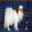

In [8]:
example = train_ds[10]
print('label :',id2label[example['label']])
example['img']

In [9]:

model = SwinForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=10,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

C:\Users\USER\AppData\Local\Temp/ipykernel_14440/3743677917.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [11]:
training_args = TrainingArguments(output_dir="./",
                                    remove_unused_columns=False,
                                  evaluation_strategy = "epoch",
                                  save_strategy = "epoch",
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=8,
                                  gradient_accumulation_steps=4,
                                  per_device_eval_batch_size=8,
                                  num_train_epochs=2,
                                  warmup_ratio=0.1,
                                  logging_steps=10,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="accuracy",
                                  )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
     

In [12]:

train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:346: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 40500
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 2530
  Number of trainable parameters = 27527044
  0%|          | 10/2530 [00:08<26:48,  1.57it/s] 

{'loss': 2.3467, 'learning_rate': 1.9762845849802374e-06, 'epoch': 0.01}


  1%|          | 20/2530 [00:14<23:46,  1.76it/s]

{'loss': 2.3364, 'learning_rate': 3.952569169960475e-06, 'epoch': 0.02}


  1%|          | 30/2530 [00:20<25:13,  1.65it/s]

{'loss': 2.3135, 'learning_rate': 5.928853754940711e-06, 'epoch': 0.02}


  2%|▏         | 40/2530 [00:26<25:24,  1.63it/s]

{'loss': 2.2276, 'learning_rate': 7.90513833992095e-06, 'epoch': 0.03}


  2%|▏         | 50/2530 [00:32<25:06,  1.65it/s]

{'loss': 2.1935, 'learning_rate': 9.881422924901186e-06, 'epoch': 0.04}


  2%|▏         | 60/2530 [00:38<25:03,  1.64it/s]

{'loss': 2.1307, 'learning_rate': 1.1857707509881423e-05, 'epoch': 0.05}


  3%|▎         | 70/2530 [00:44<24:53,  1.65it/s]

{'loss': 2.0173, 'learning_rate': 1.383399209486166e-05, 'epoch': 0.06}


  3%|▎         | 80/2530 [00:50<24:49,  1.64it/s]

{'loss': 1.8522, 'learning_rate': 1.58102766798419e-05, 'epoch': 0.06}


  4%|▎         | 90/2530 [00:56<24:50,  1.64it/s]

{'loss': 1.7259, 'learning_rate': 1.7786561264822134e-05, 'epoch': 0.07}


  4%|▍         | 100/2530 [01:02<24:35,  1.65it/s]

{'loss': 1.5045, 'learning_rate': 1.9762845849802372e-05, 'epoch': 0.08}


  4%|▍         | 110/2530 [01:08<24:36,  1.64it/s]

{'loss': 1.4513, 'learning_rate': 2.173913043478261e-05, 'epoch': 0.09}


  5%|▍         | 120/2530 [01:15<24:46,  1.62it/s]

{'loss': 1.2506, 'learning_rate': 2.3715415019762845e-05, 'epoch': 0.09}


  5%|▌         | 130/2530 [01:21<24:20,  1.64it/s]

{'loss': 1.1668, 'learning_rate': 2.5691699604743087e-05, 'epoch': 0.1}


  6%|▌         | 140/2530 [01:27<24:15,  1.64it/s]

{'loss': 1.1134, 'learning_rate': 2.766798418972332e-05, 'epoch': 0.11}


  6%|▌         | 150/2530 [01:33<24:10,  1.64it/s]

{'loss': 0.9448, 'learning_rate': 2.964426877470356e-05, 'epoch': 0.12}


  6%|▋         | 160/2530 [01:39<24:07,  1.64it/s]

{'loss': 1.1034, 'learning_rate': 3.16205533596838e-05, 'epoch': 0.13}


  7%|▋         | 170/2530 [01:45<24:00,  1.64it/s]

{'loss': 0.9682, 'learning_rate': 3.3596837944664036e-05, 'epoch': 0.13}


  7%|▋         | 180/2530 [01:51<23:52,  1.64it/s]

{'loss': 0.859, 'learning_rate': 3.557312252964427e-05, 'epoch': 0.14}


  8%|▊         | 190/2530 [01:57<23:50,  1.64it/s]

{'loss': 0.9859, 'learning_rate': 3.7549407114624506e-05, 'epoch': 0.15}


  8%|▊         | 200/2530 [02:03<23:46,  1.63it/s]

{'loss': 0.8054, 'learning_rate': 3.9525691699604744e-05, 'epoch': 0.16}


  8%|▊         | 210/2530 [02:09<23:37,  1.64it/s]

{'loss': 0.8318, 'learning_rate': 4.150197628458498e-05, 'epoch': 0.17}


  9%|▊         | 220/2530 [02:16<23:29,  1.64it/s]

{'loss': 0.8213, 'learning_rate': 4.347826086956522e-05, 'epoch': 0.17}


  9%|▉         | 230/2530 [02:22<23:29,  1.63it/s]

{'loss': 0.8686, 'learning_rate': 4.545454545454546e-05, 'epoch': 0.18}


  9%|▉         | 240/2530 [02:28<23:44,  1.61it/s]

{'loss': 0.7178, 'learning_rate': 4.743083003952569e-05, 'epoch': 0.19}


 10%|▉         | 250/2530 [02:34<23:19,  1.63it/s]

{'loss': 0.7121, 'learning_rate': 4.940711462450593e-05, 'epoch': 0.2}


 10%|█         | 260/2530 [02:40<23:05,  1.64it/s]

{'loss': 0.8041, 'learning_rate': 4.984628897672376e-05, 'epoch': 0.21}


 11%|█         | 270/2530 [02:46<22:57,  1.64it/s]

{'loss': 0.8721, 'learning_rate': 4.9626701800614844e-05, 'epoch': 0.21}


 11%|█         | 280/2530 [02:52<22:51,  1.64it/s]

{'loss': 0.7127, 'learning_rate': 4.940711462450593e-05, 'epoch': 0.22}


 11%|█▏        | 290/2530 [02:58<22:44,  1.64it/s]

{'loss': 0.6995, 'learning_rate': 4.918752744839701e-05, 'epoch': 0.23}


 12%|█▏        | 300/2530 [03:05<22:45,  1.63it/s]

{'loss': 0.7477, 'learning_rate': 4.89679402722881e-05, 'epoch': 0.24}


 12%|█▏        | 310/2530 [03:11<22:33,  1.64it/s]

{'loss': 0.6559, 'learning_rate': 4.874835309617918e-05, 'epoch': 0.24}


 13%|█▎        | 320/2530 [03:17<22:26,  1.64it/s]

{'loss': 0.6369, 'learning_rate': 4.852876592007027e-05, 'epoch': 0.25}


 13%|█▎        | 330/2530 [03:23<22:19,  1.64it/s]

{'loss': 0.8204, 'learning_rate': 4.830917874396135e-05, 'epoch': 0.26}


 13%|█▎        | 340/2530 [03:29<22:13,  1.64it/s]

{'loss': 0.7333, 'learning_rate': 4.8089591567852436e-05, 'epoch': 0.27}


 14%|█▍        | 350/2530 [03:35<22:10,  1.64it/s]

{'loss': 0.657, 'learning_rate': 4.787000439174352e-05, 'epoch': 0.28}


 14%|█▍        | 360/2530 [03:41<22:04,  1.64it/s]

{'loss': 0.6112, 'learning_rate': 4.7650417215634605e-05, 'epoch': 0.28}


 15%|█▍        | 370/2530 [03:47<22:01,  1.63it/s]

{'loss': 0.6049, 'learning_rate': 4.743083003952569e-05, 'epoch': 0.29}


 15%|█▌        | 380/2530 [03:53<21:53,  1.64it/s]

{'loss': 0.645, 'learning_rate': 4.7211242863416775e-05, 'epoch': 0.3}


 15%|█▌        | 390/2530 [04:00<21:44,  1.64it/s]

{'loss': 0.6578, 'learning_rate': 4.699165568730786e-05, 'epoch': 0.31}


 16%|█▌        | 400/2530 [04:06<21:56,  1.62it/s]

{'loss': 0.6789, 'learning_rate': 4.6772068511198944e-05, 'epoch': 0.32}


 16%|█▌        | 410/2530 [04:12<21:29,  1.64it/s]

{'loss': 0.65, 'learning_rate': 4.655248133509003e-05, 'epoch': 0.32}


 17%|█▋        | 420/2530 [04:18<21:26,  1.64it/s]

{'loss': 0.7351, 'learning_rate': 4.633289415898111e-05, 'epoch': 0.33}


 17%|█▋        | 430/2530 [04:24<21:23,  1.64it/s]

{'loss': 0.577, 'learning_rate': 4.61133069828722e-05, 'epoch': 0.34}


 17%|█▋        | 440/2530 [04:30<21:15,  1.64it/s]

{'loss': 0.4738, 'learning_rate': 4.589371980676328e-05, 'epoch': 0.35}


 18%|█▊        | 450/2530 [04:36<21:11,  1.64it/s]

{'loss': 0.631, 'learning_rate': 4.567413263065437e-05, 'epoch': 0.36}


 18%|█▊        | 460/2530 [04:42<21:03,  1.64it/s]

{'loss': 0.5863, 'learning_rate': 4.545454545454546e-05, 'epoch': 0.36}


 19%|█▊        | 470/2530 [04:48<20:58,  1.64it/s]

{'loss': 0.5986, 'learning_rate': 4.523495827843654e-05, 'epoch': 0.37}


 19%|█▉        | 480/2530 [04:55<20:52,  1.64it/s]

{'loss': 0.6057, 'learning_rate': 4.501537110232763e-05, 'epoch': 0.38}


 19%|█▉        | 490/2530 [05:01<20:43,  1.64it/s]

{'loss': 0.6575, 'learning_rate': 4.479578392621871e-05, 'epoch': 0.39}


 20%|█▉        | 500/2530 [05:07<20:39,  1.64it/s]

{'loss': 0.5577, 'learning_rate': 4.45761967501098e-05, 'epoch': 0.4}


 20%|██        | 510/2530 [05:13<20:33,  1.64it/s]

{'loss': 0.5843, 'learning_rate': 4.435660957400088e-05, 'epoch': 0.4}


 21%|██        | 520/2530 [05:19<20:27,  1.64it/s]

{'loss': 0.5598, 'learning_rate': 4.4137022397891966e-05, 'epoch': 0.41}


 21%|██        | 530/2530 [05:25<20:26,  1.63it/s]

{'loss': 0.519, 'learning_rate': 4.391743522178305e-05, 'epoch': 0.42}


 21%|██▏       | 540/2530 [05:31<20:16,  1.64it/s]

{'loss': 0.6566, 'learning_rate': 4.3697848045674136e-05, 'epoch': 0.43}


 22%|██▏       | 550/2530 [05:37<20:08,  1.64it/s]

{'loss': 0.6713, 'learning_rate': 4.347826086956522e-05, 'epoch': 0.43}


 22%|██▏       | 560/2530 [05:43<20:06,  1.63it/s]

{'loss': 0.5839, 'learning_rate': 4.3258673693456305e-05, 'epoch': 0.44}


 23%|██▎       | 570/2530 [05:50<19:59,  1.63it/s]

{'loss': 0.5884, 'learning_rate': 4.303908651734739e-05, 'epoch': 0.45}


 23%|██▎       | 580/2530 [05:56<19:58,  1.63it/s]

{'loss': 0.4569, 'learning_rate': 4.2819499341238474e-05, 'epoch': 0.46}


 23%|██▎       | 590/2530 [06:02<19:50,  1.63it/s]

{'loss': 0.7129, 'learning_rate': 4.259991216512956e-05, 'epoch': 0.47}


 24%|██▎       | 600/2530 [06:08<19:39,  1.64it/s]

{'loss': 0.5966, 'learning_rate': 4.2380324989020644e-05, 'epoch': 0.47}


 24%|██▍       | 610/2530 [06:14<19:39,  1.63it/s]

{'loss': 0.5441, 'learning_rate': 4.216073781291173e-05, 'epoch': 0.48}


 25%|██▍       | 620/2530 [06:20<19:34,  1.63it/s]

{'loss': 0.5063, 'learning_rate': 4.194115063680281e-05, 'epoch': 0.49}


 25%|██▍       | 630/2530 [06:26<19:34,  1.62it/s]

{'loss': 0.597, 'learning_rate': 4.17215634606939e-05, 'epoch': 0.5}


 25%|██▌       | 640/2530 [06:33<19:16,  1.63it/s]

{'loss': 0.5315, 'learning_rate': 4.150197628458498e-05, 'epoch': 0.51}


 26%|██▌       | 650/2530 [06:39<19:12,  1.63it/s]

{'loss': 0.5638, 'learning_rate': 4.128238910847607e-05, 'epoch': 0.51}


 26%|██▌       | 660/2530 [06:45<19:04,  1.63it/s]

{'loss': 0.5989, 'learning_rate': 4.106280193236715e-05, 'epoch': 0.52}


 26%|██▋       | 670/2530 [06:51<18:59,  1.63it/s]

{'loss': 0.5906, 'learning_rate': 4.0843214756258236e-05, 'epoch': 0.53}


 27%|██▋       | 680/2530 [06:57<18:58,  1.62it/s]

{'loss': 0.503, 'learning_rate': 4.062362758014932e-05, 'epoch': 0.54}


 27%|██▋       | 690/2530 [07:03<18:45,  1.64it/s]

{'loss': 0.498, 'learning_rate': 4.0404040404040405e-05, 'epoch': 0.55}


 28%|██▊       | 700/2530 [07:09<18:44,  1.63it/s]

{'loss': 0.5335, 'learning_rate': 4.018445322793149e-05, 'epoch': 0.55}


 28%|██▊       | 710/2530 [07:16<18:37,  1.63it/s]

{'loss': 0.5134, 'learning_rate': 3.9964866051822575e-05, 'epoch': 0.56}


 28%|██▊       | 720/2530 [07:22<18:30,  1.63it/s]

{'loss': 0.5313, 'learning_rate': 3.974527887571366e-05, 'epoch': 0.57}


 29%|██▉       | 730/2530 [07:28<18:30,  1.62it/s]

{'loss': 0.4341, 'learning_rate': 3.9525691699604744e-05, 'epoch': 0.58}


 29%|██▉       | 740/2530 [07:34<18:18,  1.63it/s]

{'loss': 0.4969, 'learning_rate': 3.930610452349583e-05, 'epoch': 0.58}


 30%|██▉       | 750/2530 [07:40<18:15,  1.62it/s]

{'loss': 0.5842, 'learning_rate': 3.908651734738691e-05, 'epoch': 0.59}


 30%|███       | 760/2530 [07:46<18:00,  1.64it/s]

{'loss': 0.5577, 'learning_rate': 3.8866930171278e-05, 'epoch': 0.6}


 30%|███       | 770/2530 [07:53<18:01,  1.63it/s]

{'loss': 0.5226, 'learning_rate': 3.864734299516908e-05, 'epoch': 0.61}


 31%|███       | 780/2530 [07:59<17:57,  1.62it/s]

{'loss': 0.5618, 'learning_rate': 3.842775581906017e-05, 'epoch': 0.62}


 31%|███       | 790/2530 [08:05<17:55,  1.62it/s]

{'loss': 0.5813, 'learning_rate': 3.820816864295125e-05, 'epoch': 0.62}


 32%|███▏      | 800/2530 [08:11<17:53,  1.61it/s]

{'loss': 0.4886, 'learning_rate': 3.7988581466842336e-05, 'epoch': 0.63}


 32%|███▏      | 810/2530 [08:17<17:39,  1.62it/s]

{'loss': 0.5127, 'learning_rate': 3.776899429073342e-05, 'epoch': 0.64}


 32%|███▏      | 820/2530 [08:23<17:27,  1.63it/s]

{'loss': 0.5245, 'learning_rate': 3.7549407114624506e-05, 'epoch': 0.65}


 33%|███▎      | 830/2530 [08:30<17:14,  1.64it/s]

{'loss': 0.5823, 'learning_rate': 3.732981993851559e-05, 'epoch': 0.66}


 33%|███▎      | 840/2530 [08:36<17:16,  1.63it/s]

{'loss': 0.5296, 'learning_rate': 3.7110232762406675e-05, 'epoch': 0.66}


 34%|███▎      | 850/2530 [08:42<17:20,  1.61it/s]

{'loss': 0.5321, 'learning_rate': 3.689064558629776e-05, 'epoch': 0.67}


 34%|███▍      | 860/2530 [08:48<17:03,  1.63it/s]

{'loss': 0.4772, 'learning_rate': 3.6671058410188844e-05, 'epoch': 0.68}


 34%|███▍      | 870/2530 [08:54<16:51,  1.64it/s]

{'loss': 0.5987, 'learning_rate': 3.645147123407993e-05, 'epoch': 0.69}


 35%|███▍      | 880/2530 [09:00<16:47,  1.64it/s]

{'loss': 0.4547, 'learning_rate': 3.6231884057971014e-05, 'epoch': 0.7}


 35%|███▌      | 890/2530 [09:06<16:52,  1.62it/s]

{'loss': 0.6252, 'learning_rate': 3.60122968818621e-05, 'epoch': 0.7}


 36%|███▌      | 900/2530 [09:13<16:45,  1.62it/s]

{'loss': 0.5787, 'learning_rate': 3.579270970575318e-05, 'epoch': 0.71}


 36%|███▌      | 910/2530 [09:19<16:35,  1.63it/s]

{'loss': 0.6368, 'learning_rate': 3.557312252964427e-05, 'epoch': 0.72}


 36%|███▋      | 920/2530 [09:25<16:30,  1.63it/s]

{'loss': 0.5596, 'learning_rate': 3.535353535353535e-05, 'epoch': 0.73}


 37%|███▋      | 930/2530 [09:31<16:22,  1.63it/s]

{'loss': 0.5182, 'learning_rate': 3.513394817742644e-05, 'epoch': 0.73}


 37%|███▋      | 940/2530 [09:37<16:11,  1.64it/s]

{'loss': 0.5337, 'learning_rate': 3.491436100131753e-05, 'epoch': 0.74}


 38%|███▊      | 950/2530 [09:43<16:09,  1.63it/s]

{'loss': 0.4593, 'learning_rate': 3.469477382520861e-05, 'epoch': 0.75}


 38%|███▊      | 960/2530 [09:50<16:08,  1.62it/s]

{'loss': 0.4881, 'learning_rate': 3.44751866490997e-05, 'epoch': 0.76}


 38%|███▊      | 970/2530 [09:56<15:55,  1.63it/s]

{'loss': 0.5502, 'learning_rate': 3.425559947299078e-05, 'epoch': 0.77}


 39%|███▊      | 980/2530 [10:02<15:56,  1.62it/s]

{'loss': 0.5619, 'learning_rate': 3.403601229688187e-05, 'epoch': 0.77}


 39%|███▉      | 990/2530 [10:08<15:40,  1.64it/s]

{'loss': 0.5539, 'learning_rate': 3.381642512077295e-05, 'epoch': 0.78}


 40%|███▉      | 1000/2530 [10:14<15:43,  1.62it/s]

{'loss': 0.4819, 'learning_rate': 3.3596837944664036e-05, 'epoch': 0.79}


 40%|███▉      | 1010/2530 [10:20<15:30,  1.63it/s]

{'loss': 0.5273, 'learning_rate': 3.337725076855512e-05, 'epoch': 0.8}


 40%|████      | 1020/2530 [10:26<15:26,  1.63it/s]

{'loss': 0.5663, 'learning_rate': 3.3157663592446205e-05, 'epoch': 0.81}


 41%|████      | 1030/2530 [10:33<15:22,  1.63it/s]

{'loss': 0.5135, 'learning_rate': 3.293807641633729e-05, 'epoch': 0.81}


 41%|████      | 1040/2530 [10:39<15:12,  1.63it/s]

{'loss': 0.5663, 'learning_rate': 3.2718489240228375e-05, 'epoch': 0.82}


 42%|████▏     | 1050/2530 [10:45<15:13,  1.62it/s]

{'loss': 0.5111, 'learning_rate': 3.249890206411946e-05, 'epoch': 0.83}


 42%|████▏     | 1060/2530 [10:51<15:03,  1.63it/s]

{'loss': 0.5229, 'learning_rate': 3.2279314888010544e-05, 'epoch': 0.84}


 42%|████▏     | 1070/2530 [10:57<15:01,  1.62it/s]

{'loss': 0.4319, 'learning_rate': 3.205972771190163e-05, 'epoch': 0.85}


 43%|████▎     | 1080/2530 [11:03<14:48,  1.63it/s]

{'loss': 0.4542, 'learning_rate': 3.184014053579271e-05, 'epoch': 0.85}


 43%|████▎     | 1090/2530 [11:09<14:45,  1.63it/s]

{'loss': 0.4282, 'learning_rate': 3.16205533596838e-05, 'epoch': 0.86}


 43%|████▎     | 1100/2530 [11:16<14:42,  1.62it/s]

{'loss': 0.5748, 'learning_rate': 3.140096618357488e-05, 'epoch': 0.87}


 44%|████▍     | 1110/2530 [11:22<14:34,  1.62it/s]

{'loss': 0.4093, 'learning_rate': 3.118137900746597e-05, 'epoch': 0.88}


 44%|████▍     | 1120/2530 [11:28<14:22,  1.63it/s]

{'loss': 0.4729, 'learning_rate': 3.096179183135705e-05, 'epoch': 0.88}


 45%|████▍     | 1130/2530 [11:34<14:21,  1.63it/s]

{'loss': 0.4697, 'learning_rate': 3.0742204655248136e-05, 'epoch': 0.89}


 45%|████▌     | 1140/2530 [11:40<14:10,  1.63it/s]

{'loss': 0.5869, 'learning_rate': 3.052261747913922e-05, 'epoch': 0.9}


 45%|████▌     | 1150/2530 [11:46<14:08,  1.63it/s]

{'loss': 0.5554, 'learning_rate': 3.0303030303030306e-05, 'epoch': 0.91}


 46%|████▌     | 1160/2530 [11:53<14:11,  1.61it/s]

{'loss': 0.3951, 'learning_rate': 3.008344312692139e-05, 'epoch': 0.92}


 46%|████▌     | 1170/2530 [11:59<13:53,  1.63it/s]

{'loss': 0.4524, 'learning_rate': 2.9863855950812475e-05, 'epoch': 0.92}


 47%|████▋     | 1180/2530 [12:05<13:47,  1.63it/s]

{'loss': 0.5604, 'learning_rate': 2.964426877470356e-05, 'epoch': 0.93}


 47%|████▋     | 1190/2530 [12:11<13:42,  1.63it/s]

{'loss': 0.505, 'learning_rate': 2.9424681598594644e-05, 'epoch': 0.94}


 47%|████▋     | 1200/2530 [12:17<13:33,  1.64it/s]

{'loss': 0.4956, 'learning_rate': 2.920509442248573e-05, 'epoch': 0.95}


 48%|████▊     | 1210/2530 [12:23<13:31,  1.63it/s]

{'loss': 0.4346, 'learning_rate': 2.8985507246376814e-05, 'epoch': 0.96}


 48%|████▊     | 1220/2530 [12:29<13:25,  1.63it/s]

{'loss': 0.5612, 'learning_rate': 2.8765920070267898e-05, 'epoch': 0.96}


 49%|████▊     | 1230/2530 [12:36<13:19,  1.63it/s]

{'loss': 0.4922, 'learning_rate': 2.8546332894158983e-05, 'epoch': 0.97}


 49%|████▉     | 1240/2530 [12:42<13:17,  1.62it/s]

{'loss': 0.4121, 'learning_rate': 2.8326745718050068e-05, 'epoch': 0.98}


 49%|████▉     | 1250/2530 [12:48<13:05,  1.63it/s]

{'loss': 0.5857, 'learning_rate': 2.8107158541941152e-05, 'epoch': 0.99}


 50%|████▉     | 1260/2530 [12:54<12:57,  1.63it/s]

{'loss': 0.4474, 'learning_rate': 2.7887571365832237e-05, 'epoch': 1.0}


 50%|█████     | 1265/2530 [12:57<12:57,  1.63it/s]***** Running Evaluation *****
  Num examples = 4500
  Batch size = 8
                                                   
 50%|█████     | 1265/2530 [13:33<12:57,  1.63it/s]Saving model checkpoint to ./checkpoint-1265
Configuration saved in ./checkpoint-1265\config.json
Model weights saved in ./checkpoint-1265\pytorch_model.bin
Image processor saved in ./checkpoint-1265\preprocessor_config.json


{'eval_loss': 0.14013083279132843, 'eval_accuracy': 0.9524444444444444, 'eval_runtime': 35.0614, 'eval_samples_per_second': 128.346, 'eval_steps_per_second': 16.058, 'epoch': 1.0}


 50%|█████     | 1270/2530 [13:36<1:07:17,  3.20s/it]

{'loss': 0.553, 'learning_rate': 2.766798418972332e-05, 'epoch': 1.0}


 51%|█████     | 1280/2530 [13:42<14:04,  1.48it/s]  

{'loss': 0.4928, 'learning_rate': 2.7448397013614406e-05, 'epoch': 1.01}


 51%|█████     | 1290/2530 [13:48<12:28,  1.66it/s]

{'loss': 0.455, 'learning_rate': 2.722880983750549e-05, 'epoch': 1.02}


 51%|█████▏    | 1300/2530 [13:54<12:28,  1.64it/s]

{'loss': 0.4614, 'learning_rate': 2.700922266139658e-05, 'epoch': 1.03}


 52%|█████▏    | 1310/2530 [14:00<12:25,  1.64it/s]

{'loss': 0.4273, 'learning_rate': 2.6789635485287663e-05, 'epoch': 1.04}


 52%|█████▏    | 1320/2530 [14:07<12:18,  1.64it/s]

{'loss': 0.4582, 'learning_rate': 2.6570048309178748e-05, 'epoch': 1.04}


 53%|█████▎    | 1330/2530 [14:13<12:11,  1.64it/s]

{'loss': 0.3703, 'learning_rate': 2.6350461133069833e-05, 'epoch': 1.05}


 53%|█████▎    | 1340/2530 [14:19<12:06,  1.64it/s]

{'loss': 0.5227, 'learning_rate': 2.6130873956960917e-05, 'epoch': 1.06}


 53%|█████▎    | 1350/2530 [14:25<11:59,  1.64it/s]

{'loss': 0.3993, 'learning_rate': 2.5911286780852002e-05, 'epoch': 1.07}


 54%|█████▍    | 1360/2530 [14:31<11:53,  1.64it/s]

{'loss': 0.4508, 'learning_rate': 2.5691699604743087e-05, 'epoch': 1.08}


 54%|█████▍    | 1370/2530 [14:37<11:49,  1.63it/s]

{'loss': 0.363, 'learning_rate': 2.547211242863417e-05, 'epoch': 1.08}


 55%|█████▍    | 1380/2530 [14:43<11:43,  1.64it/s]

{'loss': 0.455, 'learning_rate': 2.5252525252525256e-05, 'epoch': 1.09}


 55%|█████▍    | 1390/2530 [14:49<11:34,  1.64it/s]

{'loss': 0.4607, 'learning_rate': 2.503293807641634e-05, 'epoch': 1.1}


 55%|█████▌    | 1400/2530 [14:55<11:29,  1.64it/s]

{'loss': 0.5176, 'learning_rate': 2.4813350900307422e-05, 'epoch': 1.11}


 56%|█████▌    | 1410/2530 [15:02<11:25,  1.63it/s]

{'loss': 0.3345, 'learning_rate': 2.4593763724198506e-05, 'epoch': 1.11}


 56%|█████▌    | 1420/2530 [15:08<11:20,  1.63it/s]

{'loss': 0.4676, 'learning_rate': 2.437417654808959e-05, 'epoch': 1.12}


 57%|█████▋    | 1430/2530 [15:14<11:11,  1.64it/s]

{'loss': 0.3957, 'learning_rate': 2.4154589371980676e-05, 'epoch': 1.13}


 57%|█████▋    | 1440/2530 [15:20<11:06,  1.64it/s]

{'loss': 0.365, 'learning_rate': 2.393500219587176e-05, 'epoch': 1.14}


 57%|█████▋    | 1450/2530 [15:26<10:59,  1.64it/s]

{'loss': 0.3867, 'learning_rate': 2.3715415019762845e-05, 'epoch': 1.15}


 58%|█████▊    | 1460/2530 [15:32<10:53,  1.64it/s]

{'loss': 0.4648, 'learning_rate': 2.349582784365393e-05, 'epoch': 1.15}


 58%|█████▊    | 1470/2530 [15:38<10:47,  1.64it/s]

{'loss': 0.4697, 'learning_rate': 2.3276240667545014e-05, 'epoch': 1.16}


 58%|█████▊    | 1480/2530 [15:44<10:44,  1.63it/s]

{'loss': 0.4542, 'learning_rate': 2.30566534914361e-05, 'epoch': 1.17}


 59%|█████▉    | 1490/2530 [15:51<10:37,  1.63it/s]

{'loss': 0.4135, 'learning_rate': 2.2837066315327184e-05, 'epoch': 1.18}


 59%|█████▉    | 1500/2530 [15:57<10:29,  1.64it/s]

{'loss': 0.3867, 'learning_rate': 2.261747913921827e-05, 'epoch': 1.19}


 60%|█████▉    | 1510/2530 [16:03<10:24,  1.63it/s]

{'loss': 0.5409, 'learning_rate': 2.2397891963109356e-05, 'epoch': 1.19}


 60%|██████    | 1520/2530 [16:09<10:17,  1.64it/s]

{'loss': 0.3618, 'learning_rate': 2.217830478700044e-05, 'epoch': 1.2}


 60%|██████    | 1530/2530 [16:15<10:10,  1.64it/s]

{'loss': 0.4212, 'learning_rate': 2.1958717610891526e-05, 'epoch': 1.21}


 61%|██████    | 1540/2530 [16:21<10:03,  1.64it/s]

{'loss': 0.4038, 'learning_rate': 2.173913043478261e-05, 'epoch': 1.22}


 61%|██████▏   | 1550/2530 [16:27<09:58,  1.64it/s]

{'loss': 0.4228, 'learning_rate': 2.1519543258673695e-05, 'epoch': 1.23}


 62%|██████▏   | 1560/2530 [16:33<09:55,  1.63it/s]

{'loss': 0.4451, 'learning_rate': 2.129995608256478e-05, 'epoch': 1.23}


 62%|██████▏   | 1570/2530 [16:39<09:45,  1.64it/s]

{'loss': 0.4019, 'learning_rate': 2.1080368906455864e-05, 'epoch': 1.24}


 62%|██████▏   | 1580/2530 [16:46<09:40,  1.64it/s]

{'loss': 0.4311, 'learning_rate': 2.086078173034695e-05, 'epoch': 1.25}


 63%|██████▎   | 1590/2530 [16:52<09:32,  1.64it/s]

{'loss': 0.4855, 'learning_rate': 2.0641194554238033e-05, 'epoch': 1.26}


 63%|██████▎   | 1600/2530 [16:58<09:29,  1.63it/s]

{'loss': 0.3536, 'learning_rate': 2.0421607378129118e-05, 'epoch': 1.26}


 64%|██████▎   | 1610/2530 [17:04<09:21,  1.64it/s]

{'loss': 0.379, 'learning_rate': 2.0202020202020203e-05, 'epoch': 1.27}


 64%|██████▍   | 1620/2530 [17:10<09:16,  1.64it/s]

{'loss': 0.4015, 'learning_rate': 1.9982433025911287e-05, 'epoch': 1.28}


 64%|██████▍   | 1630/2530 [17:16<09:10,  1.63it/s]

{'loss': 0.4412, 'learning_rate': 1.9762845849802372e-05, 'epoch': 1.29}


 65%|██████▍   | 1640/2530 [17:22<09:05,  1.63it/s]

{'loss': 0.3902, 'learning_rate': 1.9543258673693457e-05, 'epoch': 1.3}


 65%|██████▌   | 1650/2530 [17:28<08:57,  1.64it/s]

{'loss': 0.4708, 'learning_rate': 1.932367149758454e-05, 'epoch': 1.3}


 66%|██████▌   | 1660/2530 [17:35<08:52,  1.63it/s]

{'loss': 0.4249, 'learning_rate': 1.9104084321475626e-05, 'epoch': 1.31}


 66%|██████▌   | 1670/2530 [17:41<08:49,  1.62it/s]

{'loss': 0.4385, 'learning_rate': 1.888449714536671e-05, 'epoch': 1.32}


 66%|██████▋   | 1680/2530 [17:47<08:39,  1.64it/s]

{'loss': 0.4744, 'learning_rate': 1.8664909969257795e-05, 'epoch': 1.33}


 67%|██████▋   | 1690/2530 [17:53<08:33,  1.63it/s]

{'loss': 0.4284, 'learning_rate': 1.844532279314888e-05, 'epoch': 1.34}


 67%|██████▋   | 1700/2530 [17:59<08:27,  1.63it/s]

{'loss': 0.3908, 'learning_rate': 1.8225735617039964e-05, 'epoch': 1.34}


 68%|██████▊   | 1710/2530 [18:05<08:21,  1.63it/s]

{'loss': 0.3415, 'learning_rate': 1.800614844093105e-05, 'epoch': 1.35}


 68%|██████▊   | 1720/2530 [18:11<08:16,  1.63it/s]

{'loss': 0.361, 'learning_rate': 1.7786561264822134e-05, 'epoch': 1.36}


 68%|██████▊   | 1730/2530 [18:17<08:08,  1.64it/s]

{'loss': 0.5244, 'learning_rate': 1.756697408871322e-05, 'epoch': 1.37}


 69%|██████▉   | 1740/2530 [18:23<08:02,  1.64it/s]

{'loss': 0.4594, 'learning_rate': 1.7347386912604306e-05, 'epoch': 1.38}


 69%|██████▉   | 1750/2530 [18:30<07:56,  1.64it/s]

{'loss': 0.4419, 'learning_rate': 1.712779973649539e-05, 'epoch': 1.38}


 70%|██████▉   | 1760/2530 [18:36<07:47,  1.65it/s]

{'loss': 0.4461, 'learning_rate': 1.6908212560386476e-05, 'epoch': 1.39}


 70%|██████▉   | 1770/2530 [18:42<07:44,  1.64it/s]

{'loss': 0.3687, 'learning_rate': 1.668862538427756e-05, 'epoch': 1.4}


 70%|███████   | 1780/2530 [18:48<07:39,  1.63it/s]

{'loss': 0.4388, 'learning_rate': 1.6469038208168645e-05, 'epoch': 1.41}


 71%|███████   | 1790/2530 [18:54<07:32,  1.64it/s]

{'loss': 0.4557, 'learning_rate': 1.624945103205973e-05, 'epoch': 1.41}


 71%|███████   | 1800/2530 [19:00<07:24,  1.64it/s]

{'loss': 0.3344, 'learning_rate': 1.6029863855950814e-05, 'epoch': 1.42}


 72%|███████▏  | 1810/2530 [19:06<07:20,  1.64it/s]

{'loss': 0.3321, 'learning_rate': 1.58102766798419e-05, 'epoch': 1.43}


 72%|███████▏  | 1820/2530 [19:12<07:13,  1.64it/s]

{'loss': 0.3744, 'learning_rate': 1.5590689503732984e-05, 'epoch': 1.44}


 72%|███████▏  | 1830/2530 [19:19<07:08,  1.63it/s]

{'loss': 0.4176, 'learning_rate': 1.5371102327624068e-05, 'epoch': 1.45}


 73%|███████▎  | 1840/2530 [19:25<07:02,  1.63it/s]

{'loss': 0.4087, 'learning_rate': 1.5151515151515153e-05, 'epoch': 1.45}


 73%|███████▎  | 1850/2530 [19:31<06:55,  1.64it/s]

{'loss': 0.3772, 'learning_rate': 1.4931927975406238e-05, 'epoch': 1.46}


 74%|███████▎  | 1860/2530 [19:37<06:49,  1.64it/s]

{'loss': 0.3578, 'learning_rate': 1.4712340799297322e-05, 'epoch': 1.47}


 74%|███████▍  | 1870/2530 [19:43<06:43,  1.64it/s]

{'loss': 0.5262, 'learning_rate': 1.4492753623188407e-05, 'epoch': 1.48}


 74%|███████▍  | 1880/2530 [19:49<06:37,  1.64it/s]

{'loss': 0.4395, 'learning_rate': 1.4273166447079491e-05, 'epoch': 1.49}


 75%|███████▍  | 1890/2530 [19:55<06:31,  1.63it/s]

{'loss': 0.3515, 'learning_rate': 1.4053579270970576e-05, 'epoch': 1.49}


 75%|███████▌  | 1900/2530 [20:01<06:24,  1.64it/s]

{'loss': 0.4769, 'learning_rate': 1.383399209486166e-05, 'epoch': 1.5}


 75%|███████▌  | 1910/2530 [20:08<06:19,  1.64it/s]

{'loss': 0.4344, 'learning_rate': 1.3614404918752745e-05, 'epoch': 1.51}


 76%|███████▌  | 1920/2530 [20:14<06:11,  1.64it/s]

{'loss': 0.4837, 'learning_rate': 1.3394817742643832e-05, 'epoch': 1.52}


 76%|███████▋  | 1930/2530 [20:20<06:06,  1.64it/s]

{'loss': 0.3973, 'learning_rate': 1.3175230566534916e-05, 'epoch': 1.53}


 77%|███████▋  | 1940/2530 [20:26<05:59,  1.64it/s]

{'loss': 0.434, 'learning_rate': 1.2955643390426001e-05, 'epoch': 1.53}


 77%|███████▋  | 1950/2530 [20:32<05:53,  1.64it/s]

{'loss': 0.3484, 'learning_rate': 1.2736056214317086e-05, 'epoch': 1.54}


 77%|███████▋  | 1960/2530 [20:38<05:47,  1.64it/s]

{'loss': 0.4225, 'learning_rate': 1.251646903820817e-05, 'epoch': 1.55}


 78%|███████▊  | 1970/2530 [20:44<05:42,  1.63it/s]

{'loss': 0.3899, 'learning_rate': 1.2296881862099253e-05, 'epoch': 1.56}


 78%|███████▊  | 1980/2530 [20:50<05:36,  1.63it/s]

{'loss': 0.3936, 'learning_rate': 1.2077294685990338e-05, 'epoch': 1.56}


 79%|███████▊  | 1990/2530 [20:56<05:31,  1.63it/s]

{'loss': 0.4541, 'learning_rate': 1.1857707509881423e-05, 'epoch': 1.57}


 79%|███████▉  | 2000/2530 [21:03<05:23,  1.64it/s]

{'loss': 0.36, 'learning_rate': 1.1638120333772507e-05, 'epoch': 1.58}


 79%|███████▉  | 2010/2530 [21:09<05:18,  1.63it/s]

{'loss': 0.3998, 'learning_rate': 1.1418533157663592e-05, 'epoch': 1.59}


 80%|███████▉  | 2020/2530 [21:15<05:10,  1.64it/s]

{'loss': 0.403, 'learning_rate': 1.1198945981554678e-05, 'epoch': 1.6}


 80%|████████  | 2030/2530 [21:21<05:05,  1.64it/s]

{'loss': 0.3949, 'learning_rate': 1.0979358805445763e-05, 'epoch': 1.6}


 81%|████████  | 2040/2530 [21:27<04:59,  1.64it/s]

{'loss': 0.4578, 'learning_rate': 1.0759771629336847e-05, 'epoch': 1.61}


 81%|████████  | 2050/2530 [21:33<04:54,  1.63it/s]

{'loss': 0.3809, 'learning_rate': 1.0540184453227932e-05, 'epoch': 1.62}


 81%|████████▏ | 2060/2530 [21:39<04:47,  1.64it/s]

{'loss': 0.4339, 'learning_rate': 1.0320597277119017e-05, 'epoch': 1.63}


 82%|████████▏ | 2070/2530 [21:45<04:40,  1.64it/s]

{'loss': 0.3172, 'learning_rate': 1.0101010101010101e-05, 'epoch': 1.64}


 82%|████████▏ | 2080/2530 [21:51<04:34,  1.64it/s]

{'loss': 0.3733, 'learning_rate': 9.881422924901186e-06, 'epoch': 1.64}


 83%|████████▎ | 2090/2530 [21:58<04:29,  1.63it/s]

{'loss': 0.303, 'learning_rate': 9.66183574879227e-06, 'epoch': 1.65}


 83%|████████▎ | 2100/2530 [22:04<04:22,  1.64it/s]

{'loss': 0.3212, 'learning_rate': 9.442248572683355e-06, 'epoch': 1.66}


 83%|████████▎ | 2110/2530 [22:10<04:17,  1.63it/s]

{'loss': 0.3191, 'learning_rate': 9.22266139657444e-06, 'epoch': 1.67}


 84%|████████▍ | 2120/2530 [22:16<04:10,  1.64it/s]

{'loss': 0.5257, 'learning_rate': 9.003074220465525e-06, 'epoch': 1.68}


 84%|████████▍ | 2130/2530 [22:22<04:04,  1.63it/s]

{'loss': 0.3051, 'learning_rate': 8.78348704435661e-06, 'epoch': 1.68}


 85%|████████▍ | 2140/2530 [22:28<03:58,  1.64it/s]

{'loss': 0.4549, 'learning_rate': 8.563899868247696e-06, 'epoch': 1.69}


 85%|████████▍ | 2150/2530 [22:34<03:52,  1.64it/s]

{'loss': 0.4124, 'learning_rate': 8.34431269213878e-06, 'epoch': 1.7}


 85%|████████▌ | 2160/2530 [22:40<03:46,  1.64it/s]

{'loss': 0.3828, 'learning_rate': 8.124725516029865e-06, 'epoch': 1.71}


 86%|████████▌ | 2170/2530 [22:47<03:39,  1.64it/s]

{'loss': 0.3255, 'learning_rate': 7.90513833992095e-06, 'epoch': 1.71}


 86%|████████▌ | 2180/2530 [22:53<03:34,  1.63it/s]

{'loss': 0.3834, 'learning_rate': 7.685551163812034e-06, 'epoch': 1.72}


 87%|████████▋ | 2190/2530 [22:59<03:27,  1.64it/s]

{'loss': 0.3619, 'learning_rate': 7.465963987703119e-06, 'epoch': 1.73}


 87%|████████▋ | 2200/2530 [23:05<03:21,  1.64it/s]

{'loss': 0.398, 'learning_rate': 7.246376811594203e-06, 'epoch': 1.74}


 87%|████████▋ | 2210/2530 [23:11<03:15,  1.64it/s]

{'loss': 0.2844, 'learning_rate': 7.026789635485288e-06, 'epoch': 1.75}


 88%|████████▊ | 2220/2530 [23:17<03:10,  1.63it/s]

{'loss': 0.522, 'learning_rate': 6.807202459376373e-06, 'epoch': 1.75}


 88%|████████▊ | 2230/2530 [23:23<03:03,  1.64it/s]

{'loss': 0.3543, 'learning_rate': 6.587615283267458e-06, 'epoch': 1.76}


 89%|████████▊ | 2240/2530 [23:29<02:57,  1.64it/s]

{'loss': 0.328, 'learning_rate': 6.368028107158543e-06, 'epoch': 1.77}


 89%|████████▉ | 2250/2530 [23:35<02:50,  1.64it/s]

{'loss': 0.3025, 'learning_rate': 6.148440931049627e-06, 'epoch': 1.78}


 89%|████████▉ | 2260/2530 [23:42<02:44,  1.64it/s]

{'loss': 0.3552, 'learning_rate': 5.928853754940711e-06, 'epoch': 1.79}


 90%|████████▉ | 2270/2530 [23:48<02:38,  1.64it/s]

{'loss': 0.2897, 'learning_rate': 5.709266578831796e-06, 'epoch': 1.79}


 90%|█████████ | 2280/2530 [23:54<02:32,  1.64it/s]

{'loss': 0.3907, 'learning_rate': 5.489679402722881e-06, 'epoch': 1.8}


 91%|█████████ | 2290/2530 [24:00<02:26,  1.64it/s]

{'loss': 0.3656, 'learning_rate': 5.270092226613966e-06, 'epoch': 1.81}


 91%|█████████ | 2300/2530 [24:06<02:19,  1.64it/s]

{'loss': 0.4326, 'learning_rate': 5.050505050505051e-06, 'epoch': 1.82}


 91%|█████████▏| 2310/2530 [24:12<02:14,  1.64it/s]

{'loss': 0.3078, 'learning_rate': 4.830917874396135e-06, 'epoch': 1.83}


 92%|█████████▏| 2320/2530 [24:18<02:08,  1.64it/s]

{'loss': 0.3224, 'learning_rate': 4.61133069828722e-06, 'epoch': 1.83}


 92%|█████████▏| 2330/2530 [24:24<02:02,  1.63it/s]

{'loss': 0.2886, 'learning_rate': 4.391743522178305e-06, 'epoch': 1.84}


 92%|█████████▏| 2340/2530 [24:30<01:56,  1.63it/s]

{'loss': 0.3402, 'learning_rate': 4.17215634606939e-06, 'epoch': 1.85}


 93%|█████████▎| 2350/2530 [24:37<01:50,  1.64it/s]

{'loss': 0.3443, 'learning_rate': 3.952569169960475e-06, 'epoch': 1.86}


 93%|█████████▎| 2360/2530 [24:43<01:43,  1.64it/s]

{'loss': 0.3166, 'learning_rate': 3.7329819938515594e-06, 'epoch': 1.87}


 94%|█████████▎| 2370/2530 [24:49<01:37,  1.64it/s]

{'loss': 0.36, 'learning_rate': 3.513394817742644e-06, 'epoch': 1.87}


 94%|█████████▍| 2380/2530 [24:55<01:31,  1.64it/s]

{'loss': 0.4069, 'learning_rate': 3.293807641633729e-06, 'epoch': 1.88}


 94%|█████████▍| 2390/2530 [25:01<01:25,  1.64it/s]

{'loss': 0.3479, 'learning_rate': 3.0742204655248133e-06, 'epoch': 1.89}


 95%|█████████▍| 2400/2530 [25:07<01:19,  1.64it/s]

{'loss': 0.3608, 'learning_rate': 2.854633289415898e-06, 'epoch': 1.9}


 95%|█████████▌| 2410/2530 [25:13<01:13,  1.64it/s]

{'loss': 0.43, 'learning_rate': 2.635046113306983e-06, 'epoch': 1.9}


 96%|█████████▌| 2420/2530 [25:19<01:07,  1.63it/s]

{'loss': 0.3927, 'learning_rate': 2.4154589371980677e-06, 'epoch': 1.91}


 96%|█████████▌| 2430/2530 [25:26<01:01,  1.64it/s]

{'loss': 0.3631, 'learning_rate': 2.1958717610891523e-06, 'epoch': 1.92}


 96%|█████████▋| 2440/2530 [25:32<00:54,  1.64it/s]

{'loss': 0.4476, 'learning_rate': 1.9762845849802374e-06, 'epoch': 1.93}


 97%|█████████▋| 2450/2530 [25:38<00:48,  1.64it/s]

{'loss': 0.3854, 'learning_rate': 1.756697408871322e-06, 'epoch': 1.94}


 97%|█████████▋| 2460/2530 [25:44<00:42,  1.64it/s]

{'loss': 0.4111, 'learning_rate': 1.5371102327624067e-06, 'epoch': 1.94}


 98%|█████████▊| 2470/2530 [25:50<00:36,  1.64it/s]

{'loss': 0.3872, 'learning_rate': 1.3175230566534915e-06, 'epoch': 1.95}


 98%|█████████▊| 2480/2530 [25:56<00:30,  1.63it/s]

{'loss': 0.3352, 'learning_rate': 1.0979358805445761e-06, 'epoch': 1.96}


 98%|█████████▊| 2490/2530 [26:02<00:24,  1.64it/s]

{'loss': 0.2996, 'learning_rate': 8.78348704435661e-07, 'epoch': 1.97}


 99%|█████████▉| 2500/2530 [26:08<00:18,  1.64it/s]

{'loss': 0.3498, 'learning_rate': 6.587615283267458e-07, 'epoch': 1.98}


 99%|█████████▉| 2510/2530 [26:14<00:11,  1.73it/s]

{'loss': 0.3369, 'learning_rate': 4.391743522178305e-07, 'epoch': 1.98}


100%|█████████▉| 2520/2530 [26:20<00:05,  1.78it/s]

{'loss': 0.3972, 'learning_rate': 2.1958717610891525e-07, 'epoch': 1.99}


100%|██████████| 2530/2530 [26:26<00:00,  1.78it/s]***** Running Evaluation *****
  Num examples = 4500
  Batch size = 8


{'loss': 0.3511, 'learning_rate': 0.0, 'epoch': 2.0}


                                                   
100%|██████████| 2530/2530 [26:58<00:00,  1.78it/s]Saving model checkpoint to ./checkpoint-2530
Configuration saved in ./checkpoint-2530\config.json
Model weights saved in ./checkpoint-2530\pytorch_model.bin
Image processor saved in ./checkpoint-2530\preprocessor_config.json


{'eval_loss': 0.08833599090576172, 'eval_accuracy': 0.9717777777777777, 'eval_runtime': 32.3204, 'eval_samples_per_second': 139.231, 'eval_steps_per_second': 17.419, 'epoch': 2.0}




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./checkpoint-2530 (score: 0.9717777777777777).
100%|██████████| 2530/2530 [26:58<00:00,  1.56it/s]
Saving model checkpoint to ./
Configuration saved in ./config.json
Model weights saved in ./pytorch_model.bin
Image processor saved in ./preprocessor_config.json


{'train_runtime': 1619.018, 'train_samples_per_second': 50.03, 'train_steps_per_second': 1.563, 'train_loss': 0.5658701645055778, 'epoch': 2.0}
***** train metrics *****
  epoch                    =        2.0
  train_loss               =     0.5659
  train_runtime            = 0:26:59.01
  train_samples_per_second =      50.03
  train_steps_per_second   =      1.563


In [13]:
dataset_test = load_dataset('cifar10',split='test')
dataset_test

Found cached dataset cifar10 (C:/Users/USER/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

In [14]:
model = SwinForImageClassification.from_pretrained(
    './checkpoint-2530/',
    num_labels=10,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True)

loading configuration file ./checkpoint-2530/config.json
Model config SwinConfig {
  "_name_or_path": "microsoft/swin-tiny-patch4-window7-224",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "plane",
    "1": "car",
    "2": "bird",
    "3": "cat",
    "4": "deer",
    "5": "dog",
    "6": "frog",
    "7": "horse",
    "8": "ship",
    "9": "truck"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "bird": 2,
    "car": 1,
    "cat": 3,
    "deer": 4,
    "dog": 5,
    "frog": 6,
    "horse": 7,
    "plane": 0,
    "ship": 8,
    "truck": 9
  },
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "swin",
  "num_channels": 3,
  "num_heads": [
    3,
    6,
    12,
    24
  ],
  "num_layers":

In [15]:
prepared_ds_test = dataset_test.with_transform(preprocess_val)

In [16]:
# Predictions
y_test_predict = trainer.predict(prepared_ds_test)

# Take a look at the predictions
y_test_predict

***** Running Prediction *****
  Num examples = 10000
  Batch size = 8
100%|██████████| 1250/1250 [01:12<00:00, 17.16it/s]


PredictionOutput(predictions=array([[-1.3795595 , -1.0865798 ,  0.31374252, ..., -2.0758958 ,
        -1.9242243 , -2.2798524 ],
       [ 2.288183  ,  1.3046619 , -1.8400929 , ..., -1.6009151 ,
         9.445768  , -0.386569  ],
       [ 1.8849508 ,  4.526985  , -1.8257655 , ..., -2.0384216 ,
         9.634069  , -0.0856154 ],
       ...,
       [-1.8887179 , -2.3407347 ,  0.3603206 , ..., -0.6589373 ,
        -1.3242996 , -2.0906086 ],
       [ 6.4276843 ,  6.0525246 , -0.05661407, ..., -2.9662435 ,
         0.2688176 , -0.7275618 ],
       [-1.9932609 , -1.4882847 ,  0.57215095, ..., 10.143873  ,
        -1.7015532 , -1.5447307 ]], dtype=float32), label_ids=array([3, 8, 8, ..., 5, 1, 7], dtype=int64), metrics={'test_loss': 0.08991346508264542, 'test_accuracy': 0.9705, 'test_runtime': 73.0214, 'test_samples_per_second': 136.946, 'test_steps_per_second': 17.118})